In [ ]:
# default_exp embed
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 03e Investigations in Directed Diffusions

The nature of normal diffusions is to become diffuse. As the scale of the diffusion increases, the trajectory becomes uncertain. But diffusion along a vector field is a different beast. Because the kernel now priveleges motion in a specific direction, even high scales of diffusion have relatively high probabilities. In one experiment in 03c03, we observed that after just 4 steps of diffusion, almost all of mass had been concentrated at a single point.

This motivates a number of questions:
1. What does the diffusion look like as it evolves? Does it travel along the manifold as a single glob of high probability in transit? Or does it initially become more diffuse, but then converge into a steady state of high probability on a handful of points?
2. Doubtless this answer depends on the geometry of the manifold and the features of the vector field under it. For what classes of manifold geometry and what types of vector fields do the above answers hold?

This notebook will empirically investigate these questions on a handful of toy datasets.

# Following Diffusions on the Branch

Our first test case: the branch. It's our most complex 1 manifold.

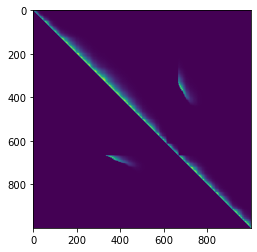

In [ ]:
# Prepare the dataset and build a diffusion matrix.
from FRED.datasets import directed_sinh_branch
from FRED.data_processing import ManifoldWithVectorField
X, flows, labels = directed_sinh_branch(num_nodes = 1000)
dataset = ManifoldWithVectorField(X, flows, labels, sigma = 0.3)

In [ ]:
P = dataset.P_graph

Print grids of P under different powers. This is the most efficient way to see the sparsity of the matrix.

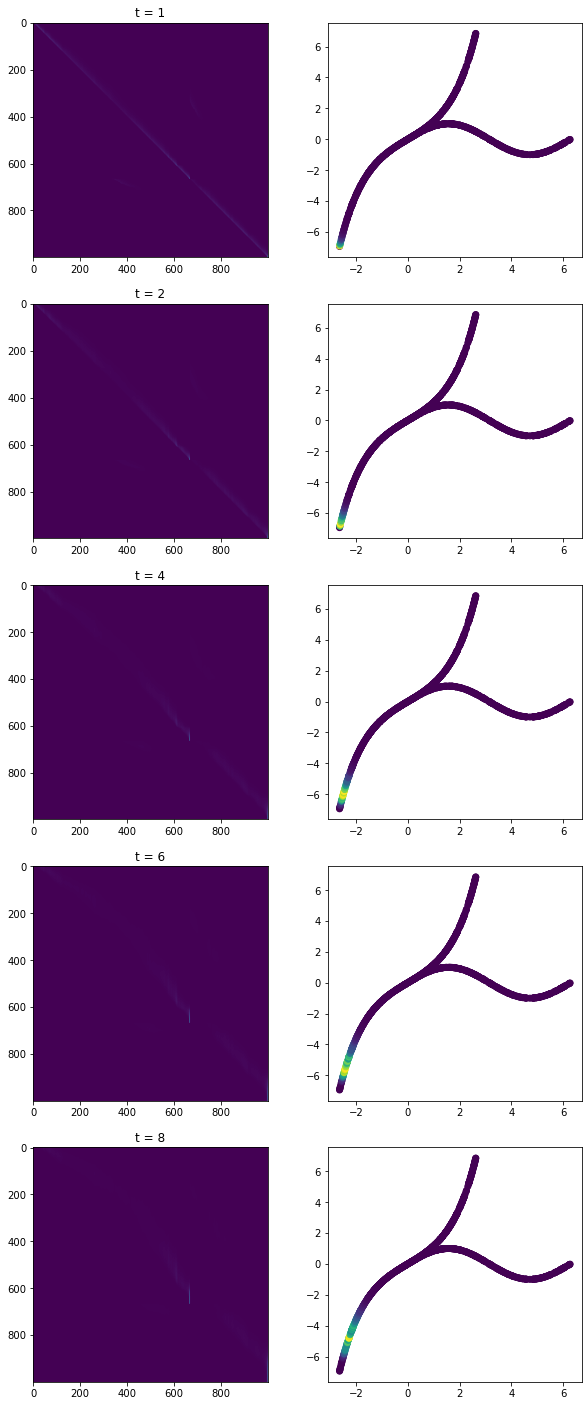

In [ ]:
ts = [1,2,4,6,8]
fig, ax = plt.subplots(len(ts), 2, figsize = (10,len(ts)*5))
for i, t in enumerate(ts):
    Pt = torch.linalg.matrix_power(P, t)
    ax[i][0].imshow(Pt)
    ax[i][0].set_title(f"t = {t}")
    ax[i][1].scatter(X[:,0], X[:,1], c = Pt[0])

In [ ]:
# export
from FRED.datasets import plot_directed_2d, plot_directed_3d
import glob
import base64
import ipywidgets as widgets
import os
from tqdm.notebook import tqdm
from PIL import Image
import datetime

def flow_gif(X, flows, P, dataset_name, max_t = 128, plot_3d = False, duration = 40):
    """Creates gif showing the t step diffusion probabilities under evolving time.
    """
    timestamp = datetime.datetime.now().isoformat()
    save_path = f"visualizations/{dataset_name}_diffusions_{timestamp}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    ts = [n for n in range(max_t)]
    for i, t in tqdm(enumerate(ts)):
        Pt = torch.linalg.matrix_power(P, t)
        title = f"{save_path}/t{i:03d}"
        if plot_3d:
            plot_directed_3d(X, flows, labels = Pt[0], save=True, filename=title, mask_prob=0)
        else:
            plot_directed_2d(X, flows, labels = Pt[0], save=True, filename=title, mask_prob=0)
    # Make gif of diffusions
    file_names = glob.glob(f"{save_path}/t*.png")
    file_names.sort()
    frames = [Image.open(image) for image in file_names]
    frame_one = frames[0]
    frame_one.save(
        f"{save_path}/_compiled.gif",
        format="GIF",
        append_images=frames,
        save_all=True,
        duration=duration,
        loop=0,
    )
    # display in jupyter notebook
    b64 = base64.b64encode(
        open(f"{save_path}/_compiled.gif", "rb").read()
    ).decode("ascii")
    display(widgets.HTML(f'<img src="data:image/gif;base64,{b64}" />'))


In [ ]:
flow_gif(X, flows, P, "directed_branch", max_t = 64)

0it [00:00, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYUAAP////7+/kQBVAAAADMzMzkASCoANgAAAAAAAAAAAAAAAAAAAA…

Results: *what does this tell us about directed diffusion?*

The most notable observation is that higher scales of directed diffusion *do not* become (much) more diffuse. The t-step diffusion probabilities travel along the manifold like a blob migrating from one side of the branch to the other. The blob initially expans slightly as it leaves the tightly concentrated diffusion neighborhood of point 0. At the end of the branch, it contracts back to a single point.


The second curiosity is that direction diffusion heavily favors one branch. Watching just this animation, it even seems doubtful that any mass is diffusing along the second branch. But this is an optical illusion. If we visualize just the period of transition, we can see some probability mass heading off the branch.

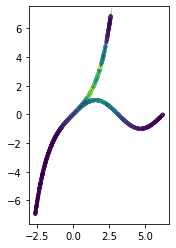

In [ ]:
Pt = torch.linalg.matrix_power(P, 30)
plot_directed_2d(X, flows, labels = Pt[0])

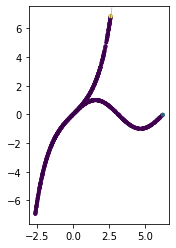

In [ ]:
Pt = torch.linalg.matrix_power(P, 50)
plot_directed_2d(X, flows, labels = Pt[0])

And, pausing at the end, you can see a slight blue tint on the end of the second branch. It still has positive transition probability, just at much lower magnitude.

This difference might reflect the design of the dataset, or some sensitivies of our flashlight kernel.


# What about a 3d surface?
In a 1 manifold, the diffusion only has one direction in which it can travel. Is this the only reason why the transition probabilities resisted becoming diffuse even for large time steps?

We'll test the same method on a couple of 2 manifolds, starting with the Swiss Roll. The hypothesis is that the higher step diffusions will be more diffuse than on the 1 manifold, but still retain some "blob"-like uniformity. They might resemble an n-ball rather than a streak on a line, but the n-ball will travel as a unit.

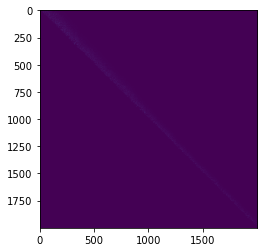

In [ ]:
# Prepare the dataset and build a diffusion matrix.
from FRED.datasets import directed_swiss_roll_delayed
from FRED.data_processing import ManifoldWithVectorField
X, flows, labels = directed_swiss_roll_delayed(num_nodes = 2000)
dataset = ManifoldWithVectorField(X, flows, labels, sigma = 1.2)
P = dataset.P_graph

In [ ]:
flow_gif(X, flows, P, "swiss_roll", max_t = 50, plot_3d = True, duration = 200)

0it [00:00, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYYAAP////v7+ylHizUocufp6q3H2cnZ5TAze5G30Sw7gsfHydbX2D…

Here's that same thing, on the diffusion coordinates of the roll.
(Note that this diffusion map has not completely unrolled the roll, giving the appearnace of back-tracking.)

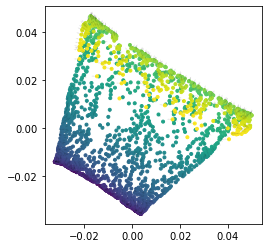

In [ ]:
X_diffmap = dataset.diff_coords
plot_directed_2d(X_diffmap, flows, labels)

In [ ]:
flow_gif(X_diffmap, flows, P, "swiss_roll", max_t = 50, plot_3d = False, duration = 200)

0it [00:00, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYUAAP////7+/kQDVDwASwAAAO3o7jMzM1UYY9XH2Gs3d8m3zrGXuK…

Let's try the same thing on a sine ribbon

Set sigma =  0.6951124


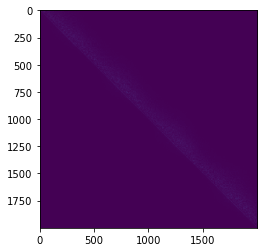

In [ ]:
# Prepare the dataset and build a diffusion matrix.
from FRED.datasets import directed_sine_ribbon
from FRED.data_processing import ManifoldWithVectorField
X, flows, labels = directed_sine_ribbon(num_nodes = 2000)
dataset = ManifoldWithVectorField(X, flows, labels, sigma = "automatic")
P = dataset.P_graph

For context, this is the dataset. Note that it's arranged horizontally, lying on the xy plane.

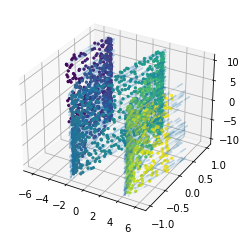

In [ ]:
plot_directed_3d(X, flows, labels)

In [ ]:
flow_gif(X, flows, P, "sine_ribbon", max_t = 50, plot_3d = True, duration = 200)

0it [00:00, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYYAAP////v7++fp6ihGizMncsfHyNbX2C8zfCs7grq7u8va5a7H2T…

The flows here seem to be behaving exactly as expected. They snake around the sine waves from front to back.

## How about a torus?

Just to make things a little crazy, here's one last 3d dataset.

Set sigma =  0.5027583


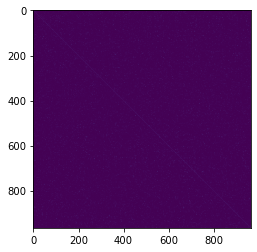

In [ ]:
# Prepare the dataset and build a diffusion matrix.
from FRED.datasets import directed_torus
from FRED.data_processing import ManifoldWithVectorField
X, flows, labels = directed_torus()
dataset = ManifoldWithVectorField(X, flows, labels, sigma = "automatic")
P = dataset.P_graph

Here's the actual thing:

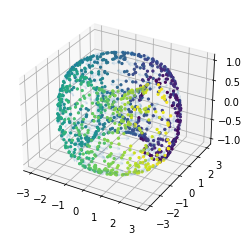

In [ ]:
plot_directed_3d(X, flows, labels)

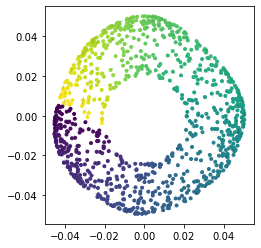

In [ ]:
plot_directed_2d(dataset.diff_coords,flows, labels)

And here's an evolving flow:

In [ ]:
flow_gif(X, flows, P, "torus", max_t = 100, plot_3d = True, duration = 200)

0it [00:00, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYYAAP////r6+ufp68fHytbW2EQIWToXZrm6u8vZ5Nnj6jYmcUYXY7…

The torus likely illustrates the increasing diffusivity of high-step diffusion probabilities better than any other dataset. As the number of steps increases, the initially tightly concentrated diffusion mass spreads out until it somewhat evenly blankets the surface.